<a href="https://colab.research.google.com/github/juelha/IANNWTF/blob/sabine/hw08_Sabine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import tensorflow as tf 
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [126]:
# dataset and preprosessing
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# a seperate tensor used for later modelling
for_TSNE = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# the tensors we will use for the main model
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)

def add_noise(images): 
  return tf.add(images, tf.random.normal((28,28,1), mean=0, stddev=0.5))

def preprocessing(tensor):
  tensor = tensor.map(lambda tensor: (tf.cast(tensor, tf.float32) / 255.)) # normalise
  tensor = tensor.map(lambda tensor: (tf.expand_dims(tensor, -1))) # make 3D tensor in case we add more filters
  tensor = tensor.map(lambda tensor: (add_noise(tensor), tensor)) # add noise with random 28,28 matrix 
  tensor = tensor.map(lambda images, target: (tf.clip_by_value(images, clip_value_min=0, clip_value_max=1), target)) # keep values normalised by clipping even after having added noise
  # the normal cache, shuffle, batch, prefetch
  tensor = tensor.cache()
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(32)
  tensor = tensor.prefetch(20)
  return tensor

train_dataset = x_train.apply(preprocessing)
test_dataset = x_test.apply(preprocessing)

# seperate processing for the t-SNE that includes an unnoisy image and the actual number target
def preprocessing_TSNE(tensor): 
  tensor = tensor.map(lambda image, target: (tf.cast(image, tf.float32) / 255., target))
  tensor = tensor.map(lambda image, target: (tf.expand_dims(image, -1), target))
  tensor = tensor.cache()
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(32)
  tensor = tensor.prefetch(20)
  return tensor

for_TSNE = for_TSNE.apply(preprocessing_TSNE)


# for plotting
for image, target in test_dataset: 
  image_model = image
  image_noisy = image.numpy()
  print(image_model.shape, image_noisy.shape)
  break

print(train_dataset)
print(tf.data.experimental.cardinality(train_dataset), tf.data.experimental.cardinality(test_dataset))

(32, 28, 28, 1) (32, 28, 28, 1)
<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float32)>
tf.Tensor(1875, shape=(), dtype=int64) tf.Tensor(313, shape=(), dtype=int64)


In [100]:
# Encoder class with a default embedding latency size of 10
class Encoder(tf.keras.Model): 
  def __init__(self, latent_dim=10): 
    super(Encoder, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu', input_shape=(28, 28)) # reduce feature map to (14,14,32) with striding
    self.maxpooling = tf.keras.layers.MaxPooling2D((2,2)) # pool to map of size (7,7,32) 
    self.flatten = tf.keras.layers.Flatten() # flatten for dense layer
    self.dense1 = tf.keras.layers.Dense(7*7*64, activation='relu') # neat trick to ensure the shapes match for reshaping in the decoder
    self.dense2 = tf.keras.layers.Dense(latent_dim) # final output for decoder

  @tf.function
  def call(self, input):
    x = self.conv1(input)
    x = self.maxpooling(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return x

In [105]:
# Decoder class to restore dimensionality again of the image, uses ouput of encoder as input
class Decoder(tf.keras.Model): 
  def __init__(self):
    super(Decoder, self).__init__()
    self.dense = tf.keras.layers.Dense(7*7*64, activation='relu') # ensure a correct number of neurons for reshaping
    self.reshape = tf.keras.layers.Reshape((7,7,64)) # restore image into 3 dimensions
    self.transconv = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(6,6), strides=(3,3), padding='valid', activation='relu') # shape here is (1, 24, 24, 32). Also valid padding means here zero padding which increases the size (opposite to a normal conv layer)
    self.transconv2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(5,5), padding='valid', activation='relu') # shape (1, 28, 28, 32)
    self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='ReLU') #finally, reduce filters to 1 binary function ouput (1, 28, 28, 1) and sigmoid function to produce an output image

  @tf.function
  def call(self, input): 
    x = self.dense(input)
    x = self.reshape(x)
    x = self.transconv(x)
    x = self.transconv2(x)
    x = self.out(x)
    return x


In [ ]:
# Autoencoder class which consists of an encoder and a decoder, which can be called independently using Autoencoder.encoder or Autoencoder.decoder
class Autoencoder(tf.keras.Model): 
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  @tf.function
  def call(self, input): 
    x = self.encoder(input)
    x = self.decoder(x)
    return x


# shape testing section
image_shape = (1, 28,28,3)
dummy = tf.ones(image_shape)
model = Autoencoder()
model(dummy)
model.summary()


In [57]:
# training and testing section
def train_step(model, input, target, loss_function, optimizer):
  """Applys optimizer to all trainable variables of this model to
  minimize the loss (loss_function) between the target output and the
  predicted ouptut.
  :param input: tf.Tensor input to the model
  :param target: target output with repect to the input
  :return: the loss and the accuracy of the models prediction
   """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  """Calculate the mean loss and accuracy of the model over all elements
  of test_data.
  :param test_data: model is evaulated for test_data
  :param: loss_function: chosen cost function
  :return: mean loss and mean accuracy for all datapoints
  """

  # test over complete test data
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = tf.reduce_mean(test_loss_aggregator)
  #test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
  return test_loss

In [106]:
# finally putting it all together. 
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = Autoencoder()
# Initialize the loss.
cross_entropy_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []

#testing once before we begin
test_loss = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)

#check how model performs on train data once before we begin
train_loss = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} with test loss: {test_losses[-1]}')
    
    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)
    print(f'Train Losses: {train_loss}, Test Losses: {test_loss}')

Epoch: 0 with test loss: 0.11397219449281693
Train Losses: 0.01216105092316866, Test Losses: 0.015027341432869434
Epoch: 1 with test loss: 0.015027341432869434
Train Losses: 0.011469483375549316, Test Losses: 0.01312324870377779
Epoch: 2 with test loss: 0.01312324870377779
Train Losses: 0.013151418417692184, Test Losses: 0.012135539203882217
Epoch: 3 with test loss: 0.012135539203882217
Train Losses: 0.011205391027033329, Test Losses: 0.012004105374217033
Epoch: 4 with test loss: 0.012004105374217033
Train Losses: 0.009967837482690811, Test Losses: 0.011292015202343464
Epoch: 5 with test loss: 0.011292015202343464
Train Losses: 0.010752787813544273, Test Losses: 0.011224864050745964
Epoch: 6 with test loss: 0.011224864050745964
Train Losses: 0.011610420420765877, Test Losses: 0.011128422804176807
Epoch: 7 with test loss: 0.011128422804176807
Train Losses: 0.009874355047941208, Test Losses: 0.011073358356952667
Epoch: 8 with test loss: 0.011073358356952667
Train Losses: 0.00921355746686

Noisy Image:


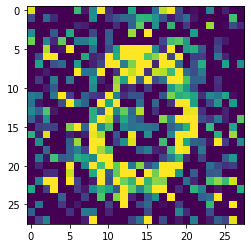

After Model:


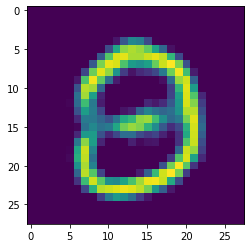

In [127]:
# Comparing noisy images to the reconstructed images that have passed through the model

images = model(image_model)
images = images.numpy()

number = 3 # change this to see other number's from the test set
print('Noisy Image:')
plt.imshow(np.squeeze(image_noisy[number]))
plt.show()
print('After Model:')
plt.imshow(np.squeeze(images[number]))
plt.show()

(1000,)
<class 'numpy.ndarray'> (1000, 2)


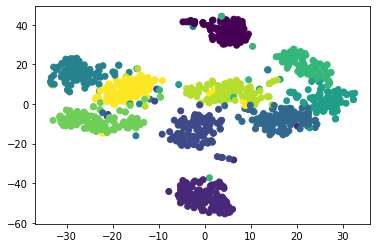

In [110]:
# Latent space analyisis
# taking the first 1000 elements from the encoder, reducing the dimensionality of the embeddings to two using t-SNE Then plotted, according to their class

test_1000 = for_TSNE.unbatch().take(1000).batch(1000) 
encoder = model.encoder

for image, target in test_1000:
  #print(image.shape)
  output = encoder(image).numpy()
  targets = target.numpy()
  print(targets.shape)


embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(output)
print(type(embedded), embedded.shape)

scatter = plt.scatter(x=embedded[:,0],y=embedded[:,1], c=targets, label=targets)


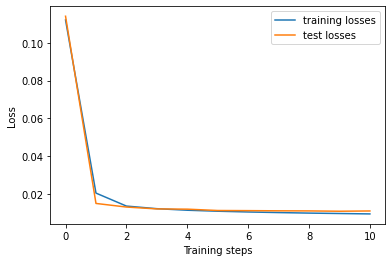

In [109]:
# Visualising the loss for training and test data

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training losses","test losses"))
plt.show()

In [103]:
''' With ReLU output act function
Epoch: 0 with test loss: 0.11394398659467697
Train Losses: 0.012479174882173538, Test Losses: 0.015729568898677826
Epoch: 1 with test loss: 0.015729568898677826
Train Losses: 0.013760209083557129, Test Losses: 0.014141666702926159
Epoch: 2 with test loss: 0.014141666702926159
Train Losses: 0.016173753887414932, Test Losses: 0.013332214206457138
Epoch: 3 with test loss: 0.013332214206457138
Train Losses: 0.011437274515628815, Test Losses: 0.01272543054074049
Epoch: 4 with test loss: 0.01272543054074049
Train Losses: 0.010972761549055576, Test Losses: 0.012433174066245556
Epoch: 5 with test loss: 0.012433174066245556
Train Losses: 0.012842413038015366, Test Losses: 0.01216734666377306
Epoch: 6 with test loss: 0.01216734666377306
Train Losses: 0.011211610399186611, Test Losses: 0.012082146480679512
Epoch: 7 with test loss: 0.012082146480679512
Train Losses: 0.011091058142483234, Test Losses: 0.01200890727341175
Epoch: 8 with test loss: 0.01200890727341175
Train Losses: 0.011684711091220379, Test Losses: 0.011831773445010185
Epoch: 9 with test loss: 0.011831773445010185
'''

''' With sigmoid 
Epoch: 0 with test loss: 0.231459379196167
Train Losses: 0.11666858196258545, Test Losses: 0.1139989122748375
Epoch: 1 with test loss: 0.1139989122748375
Train Losses: 0.11724871397018433, Test Losses: 0.11398673802614212
Epoch: 2 with test loss: 0.11398673802614212
Train Losses: 0.12434495985507965, Test Losses: 0.11399329453706741
Epoch: 3 with test loss: 0.11399329453706741
Train Losses: 0.13055045902729034, Test Losses: 0.11398440599441528
Epoch: 4 with test loss: 0.11398440599441528
Train Losses: 0.11028693616390228, Test Losses: 0.11396195739507675
Epoch: 5 with test loss: 0.11396195739507675
'''

SyntaxError: ignored